In [1]:
import pandas as pd
import xarray as xr
import openpyxl
import numpy as np

import sys

sys.path.append("..")
from cge_modeling.gams.from_excel import load_all_sheets_as_xarray, make_code_dicts

path = "data/GTAP_raw_data.xlsx"
data_vars = load_all_sheets_as_xarray(path)
gtap = xr.Dataset(data_vars).fillna(0)
code_dicts = make_code_dicts(path)

In [2]:
activities = list(code_dicts["activity"].values())
factors = list(code_dicts["factor"].values())
commodities = list(code_dicts["commodity"].values())
energy = list(code_dicts["energy"].values())

In [3]:
country_codes = sorted(list(code_dicts["country"].keys()))

factor_codes = sorted(list(code_dicts["factor"].keys()))
labor_codes = list(code_dicts["labor"].keys())
commodity_codes = sorted(list(code_dicts["commodity"].keys()))
energy_codes = [code_dicts["energy"].keys()]

factor_pp = gtap["Primary Factor Purchases"].sel(country=country_codes, price="PP")
factor_bp = gtap["Primary Factor Purchases"].sel(country=country_codes, price="BP")

factor_subsidity = gtap["Factor Subsidy Payments (Gross)"].sel(country=country_codes)
factor_tax = gtap["Factor Employment Tax Rev"].sel(country=country_codes)
factor_income = gtap["Endowment Supply Value (Net)"].sel(country=country_codes)

labor = (
    gtap.sel(country=country_codes)["Primary Factor Purchases"]
    .sel(factor=labor_codes)
    .sum(dim="factor")
)
L_bp = labor.sel(price="BP")
L_pp = labor.sel(price="PP")

K_bp = (
    gtap.sel(country=country_codes, price="BP")["Primary Factor Purchases"]
    .sel(factor=["Capital"])
    .sum(dim="factor")
)
K_pp = (
    gtap.sel(country=country_codes, price="PP")["Primary Factor Purchases"]
    .sel(factor=["Capital"])
    .sum(dim="factor")
)

NR_bp = gtap.sel(country=country_codes, price="BP")["Primary Factor Purchases"].sel(
    factor="NatlRes"
)
NR_pp = gtap.sel(country=country_codes, price="PP")["Primary Factor Purchases"].sel(
    factor="NatlRes"
)

land_bp = gtap.sel(country=country_codes, price="BP")["Primary Factor Purchases"].sel(factor="Land")
land_pp = gtap.sel(country=country_codes, price="PP")["Primary Factor Purchases"].sel(factor="Land")

F_pp = gtap.sel(country=country_codes, price="PP", agent="Firms")["Domestic Purchases"]
F_bp = gtap.sel(country=country_codes, price="BP", agent="Firms")["Domestic Purchases"]

Fi_pp = gtap.sel(country=country_codes, price="PP", agent="Firms")["Import Purchases"]
Fi_bp = gtap.sel(country=country_codes, price="BP", agent="Firms")["Import Purchases"]

F_tax = F_pp - F_bp
Fi_tax = Fi_pp - Fi_bp

X_pp = gtap.sel(country=country_codes, tax="After Tax")["Make Matrix"]
X_bp = gtap.sel(country=country_codes, tax="Before Tax")["Make Matrix"]

C_bp = gtap.sel(country=country_codes, price="BP", agent="HH")["Domestic Purchases"]
C_pp = gtap.sel(country=country_codes, price="PP", agent="HH")["Domestic Purchases"]
Ci_bp = gtap.sel(country=country_codes, price="BP", agent="HH")["Import Purchases"]
Ci_pp = gtap.sel(country=country_codes, price="PP", agent="HH")["Import Purchases"]

I_bp = gtap.sel(country=country_codes, price="BP", agent="Inv")["Domestic Purchases"]
I_pp = gtap.sel(country=country_codes, price="PP", agent="Inv")["Domestic Purchases"]
Ii_bp = gtap.sel(country=country_codes, price="BP", agent="Inv")["Import Purchases"]
Ii_pp = gtap.sel(country=country_codes, price="PP", agent="Inv")["Import Purchases"]

C_G_bp = gtap.sel(country=country_codes, price="BP", agent="Gov")["Domestic Purchases"]
C_G_pp = gtap.sel(country=country_codes, price="PP", agent="Gov")["Domestic Purchases"]

Ci_G_bp = gtap.sel(country=country_codes, price="BP", agent="Gov")["Import Purchases"]
Ci_G_pp = gtap.sel(country=country_codes, price="PP", agent="Gov")["Import Purchases"]

Im_cif = (
    gtap["Trade"]
    .sel(destination=country_codes, tariff="CIF Price", trade="Imports")
    .rename({"destination": "country"})
)
Im_bp = (
    gtap["Trade"]
    .sel(destination=country_codes, tariff="Base Price", trade="Imports")
    .rename({"destination": "country"})
)

Ex_fob = (
    gtap["Trade"]
    .sel(source=country_codes, tariff="FOB Price", trade="Exports")
    .rename({"source": "country"})
)
Ex_bp = (
    gtap["Trade"]
    .sel(source=country_codes, tariff="Base Price", trade="Exports")
    .rename({"source": "country"})
)

export_of_margin_services = gtap["Margin Exports"].sel(price="BP", country=country_codes)
margins_on_imports = (
    gtap["Margin Usage"].sel(destination=country_codes).rename({"destination": "country"})
)
margins_on_exports = gtap["Margin Usage"].sel(source=country_codes).rename({"source": "country"})


S = gtap["Net Saving"].sel(country=country_codes)
K_dep = gtap["Capital Depreciation"].sel(country=country_codes)
K_stock = gtap["Capital Stock"].sel(country=country_codes)

output_tax = gtap["Net Output Tax"].sum(dim="commodity")

# XArray of SAMs

In [4]:
def create_SAM_multiindex(commodities, factors, institutions, margins):
    index = [("Imported Commodities",) + (commoditiy,) for commoditiy in commodities]
    index += [("Domestic Commodities",) + (commoditiy,) for commoditiy in commodities]
    index += [("Activities",) + (commodity,) for commodity in commodities]
    index += [("Factors",) + (factor,) for factor in factors]
    index += [("Institution",) + (institution,) for institution in institutions]
    index += [("Domestic Sales Tax",) + (commodity,) for commodity in commodities]
    index += [("Import Sales Tax",) + (commodity,) for commodity in commodities]
    index += [("Factor Tax",) + (factor,) for factor in factors]
    index += [("Factor Subsidity",) + (factor,) for factor in factors]
    index += [("Tax", "Import Duty")]
    index += [("Tax", "Export Duty")]
    index += [("Tax", "Production")]
    index += [("Tax", "Income")]
    index += [("Import Margin",) + (margin,) for margin in margins]
    index += [("Export Margin",) + (margin,) for margin in margins]

    index += [("Trade", "Rest of World")]
    index += [("Other", "Capital Depreciation")]

    index = pd.MultiIndex.from_tuples(index)
    return index

In [5]:
institutions = ["Regional Household", "Private Household", "Government", "Investment"]
margin_codes = list(code_dicts["margin"].keys())

row_index = create_SAM_multiindex(commodity_codes, factor_codes, institutions, margin_codes)
row_index.names = ["row_group", "row_value"]

col_index = create_SAM_multiindex(commodity_codes, factor_codes, institutions, margin_codes)
col_index.names = ["col_group", "col_value"]


country_to_code = {v: k for k, v in code_dicts["country"].items()}
n = len(row_index)
r = len(country_to_code)
df = xr.DataArray(
    np.zeros((n, n, r)),
    dims=["row", "column", "country"],
    coords={
        "country": sorted(list(country_to_code.values())),
        "row": row_index,
        "column": col_index,
    },
)

## Row 1: Activities

In [6]:
def check_resid(xr, group):
    if isinstance(group, str):
        return (
            (
                xr.sel(row_group=group).sum(dim="column").rename({"row_value": "value"})
                - xr.sel(col_group=group).sum(dim="row").rename({"col_value": "value"})
            )
        ).sum(dim="value")
    elif isinstance(group, tuple):
        group, group_value = group
        return (
            xr.sel(row_group=group, row_value=group_value).rename({"column": "value"})
            - xr.sel(col_group=group, col_value=group_value).values
        ).sum(dim="value")

In [7]:
def align_coords(arr, row, col):
    align_map = {
        "Activities": "activity",
        "Domestic Commodities": "commodity",
        "Imported Commodities": "commodity",
        "Factors": "factor",
        "Factor Tax": "factor",
        "Factor Subsidity": "factor",
        "Domestic Sales Tax": "commodity",
        "Import Sales Tax": "commodity",
        "Import Duty": "commodity",
        "Export Duty": "commodity",
        "Import Margin": "margin",
        "Export Margin": "margin",
    }

    special_case_renames = {"Import Duty": "Imported Commodities"}

    def get_tuple_none_or_raise(x):
        if isinstance(x, tuple):
            return None
        return align_map[x]

    dims = arr.dims
    rename_dict = {get_tuple_none_or_raise(row): "row", get_tuple_none_or_raise(col): "column"}

    for dim, group in zip(rename_dict.keys(), [row, col]):
        if dim is None:
            # Ignore tuple index
            continue
        group = special_case_renames.get(group, group)
        index = pd.MultiIndex.from_tuples([(group,) + (value,) for value in arr.coords[dim].values])
        arr = arr.assign_coords(xr.Coordinates.from_pandas_multiindex(index, dim))

    # Don't rename unused indices
    rename_dict = {k: v for k, v in rename_dict.items() if k is not None}
    return arr.rename(rename_dict)


def make_index_dict(row_group, col_group):
    idx = {}
    for name, value in zip(["row", "col"], [row_group, col_group]):
        if isinstance(value, tuple):
            idx[f"{name}_group"] = value[0]
            idx[f"{name}_value"] = value[1]
        else:
            idx[f"{name}_group"] = value
    return idx


def update_block(df, X, row_group, col_group):
    df = df.copy()
    X_aligned = align_coords(X, row_group, col_group)
    s = make_index_dict(row_group, col_group)
    df.loc[s] = X_aligned
    return df

## Row 1: Activities

In [8]:
df = update_block(df, X_pp, "Activities", "Domestic Commodities")
df = update_block(df, F_bp, "Domestic Commodities", "Activities")
df = update_block(df, Fi_bp, "Imported Commodities", "Activities")
df = update_block(df, F_tax, "Domestic Sales Tax", "Activities")
df = update_block(df, Fi_tax, "Import Sales Tax", "Activities")
df = update_block(df, factor_bp, "Factors", "Activities")
df = update_block(df, factor_tax, "Factor Tax", "Activities")
df = update_block(df, factor_subsidity, "Factor Subsidity", "Activities")
df = update_block(df, output_tax.sel(country=country_codes), ("Tax", "Production"), "Activities")

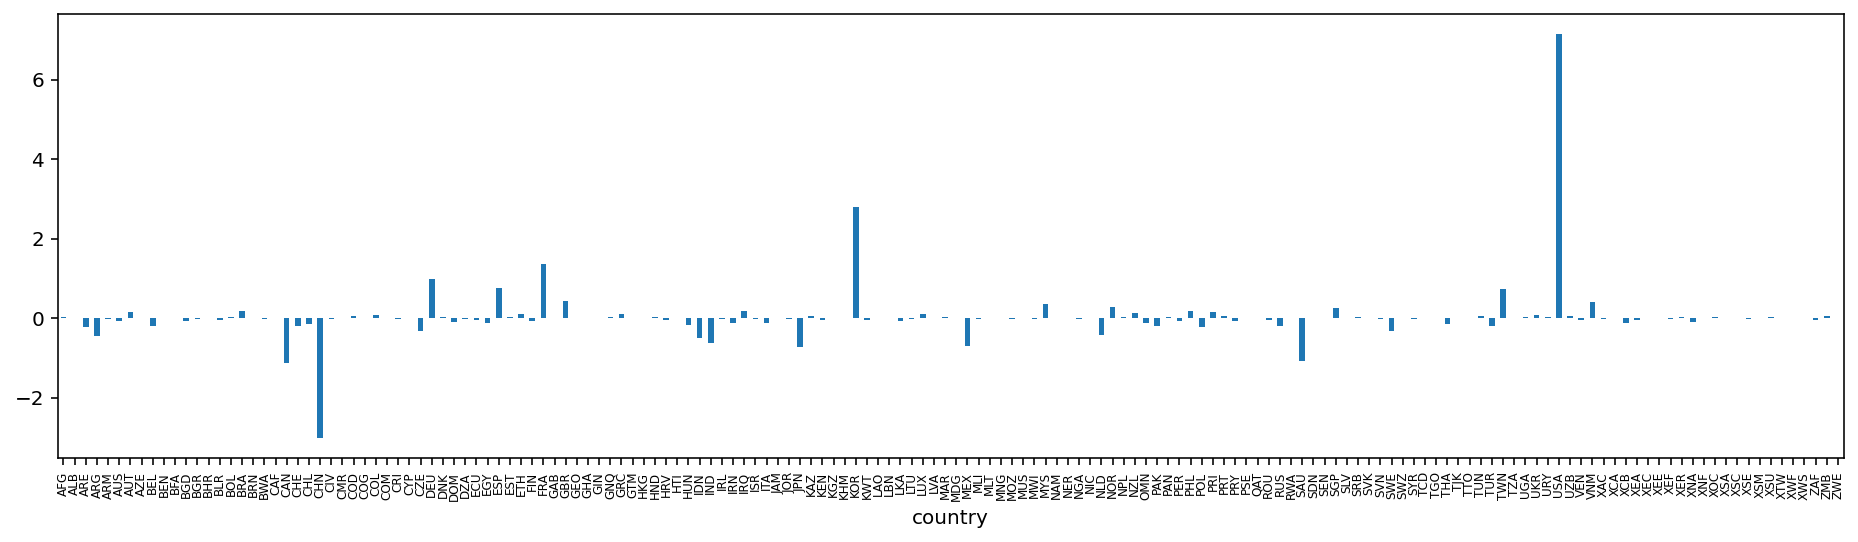

In [9]:
import matplotlib.pyplot as plt


def plot_1d_resid(resid):
    fig, ax = plt.subplots(figsize=(16, 4), dpi=144)
    resid.to_dataframe(name="resid").resid.plot.bar(ax=ax)
    ax.tick_params(axis="x", labelsize=6)
    plt.show()


plot_1d_resid(check_resid(df, "Activities"))

## Row 2: Imported Commodities

In [10]:
df = update_block(
    df, Ci_bp.sum(dim="activity"), "Imported Commodities", ("Institution", "Private Household")
)
df = update_block(
    df, Ci_G_bp.sum(dim="activity"), "Imported Commodities", ("Institution", "Government")
)
df = update_block(
    df, Ii_bp.sum(dim="activity"), "Imported Commodities", ("Institution", "Investment")
)

import_duties = Im_bp - Im_cif
df = update_block(
    df, import_duties.sum(dim="source"), ("Tax", "Import Duty"), "Imported Commodities"
)

Im_margin = margins_on_imports.sel(margin=margin_codes).sum(dim=["source"])
df = update_block(df, Im_margin, "Import Margin", "Imported Commodities")
df = update_block(
    df,
    Im_cif.sum(dim="source") - Im_margin.sum(dim=["margin"]),
    ("Trade", "Rest of World"),
    "Imported Commodities",
)

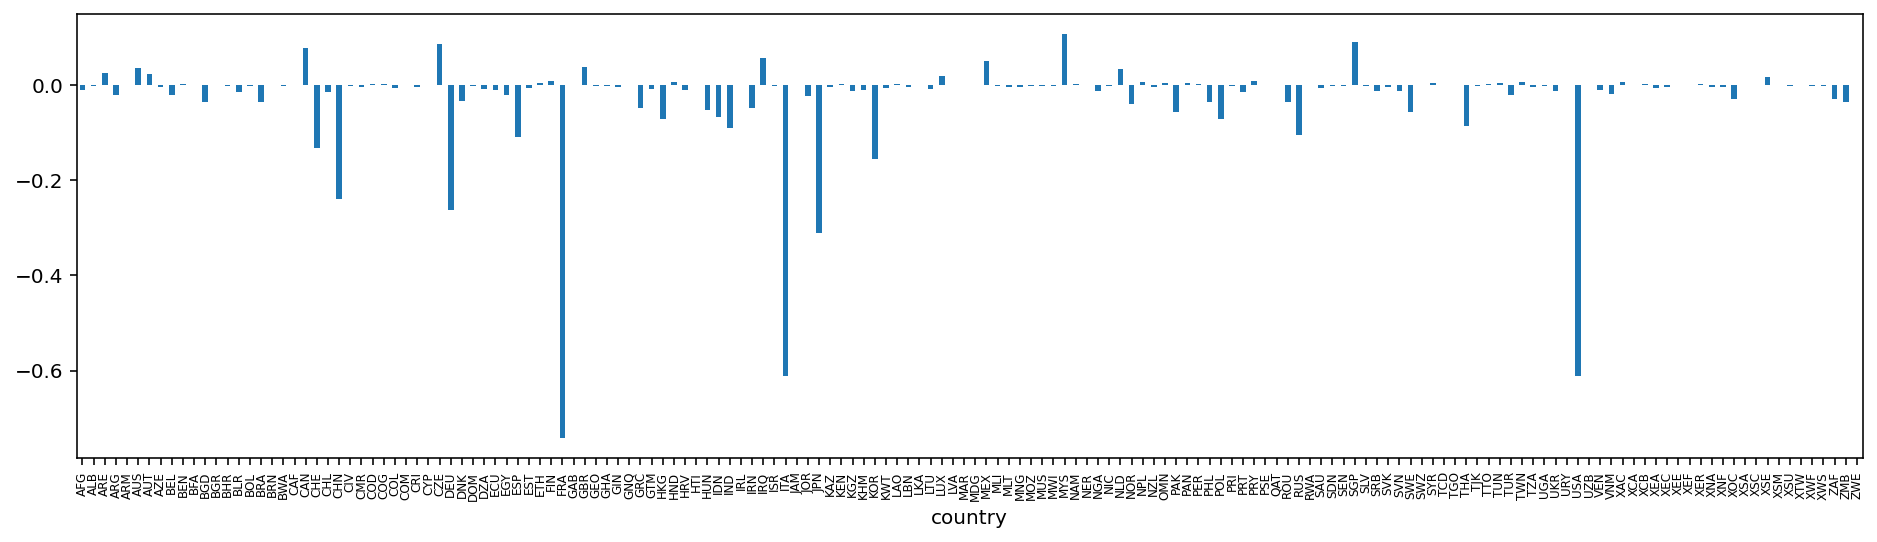

In [11]:
plot_1d_resid(check_resid(df, "Imported Commodities"))

## Row 3: Domestic Commodities

In [12]:
stacked_diag_margin = np.stack(
    [np.diag(export_of_margin_services.values[..., i]) for i in range(160)]
)
export_of_margin_services_2 = xr.DataArray(
    stacked_diag_margin,
    coords={
        "country": sorted(list(country_to_code.values())),
        "commodity": sorted(commodity_codes),
        "margin": sorted(commodity_codes),
    },
    dims=["country", "commodity", "margin"],
).sel(margin=margin_codes)

In [13]:
df = update_block(
    df, C_bp.sum(dim="activity"), "Domestic Commodities", ("Institution", "Private Household")
)
df = update_block(
    df, C_G_bp.sum(dim="activity"), "Domestic Commodities", ("Institution", "Government")
)
df = update_block(
    df, I_bp.sum(dim="activity"), "Domestic Commodities", ("Institution", "Investment")
)

total_exports = Ex_fob.sum(dim=["destination"])
df = update_block(df, total_exports, "Domestic Commodities", ("Trade", "Rest of World"))
df = update_block(df, export_of_margin_services_2, "Domestic Commodities", "Export Margin")

export_duties = Ex_fob - Ex_bp
df = update_block(
    df, export_duties.sum(dim="destination"), ("Tax", "Export Duty"), "Domestic Commodities"
)

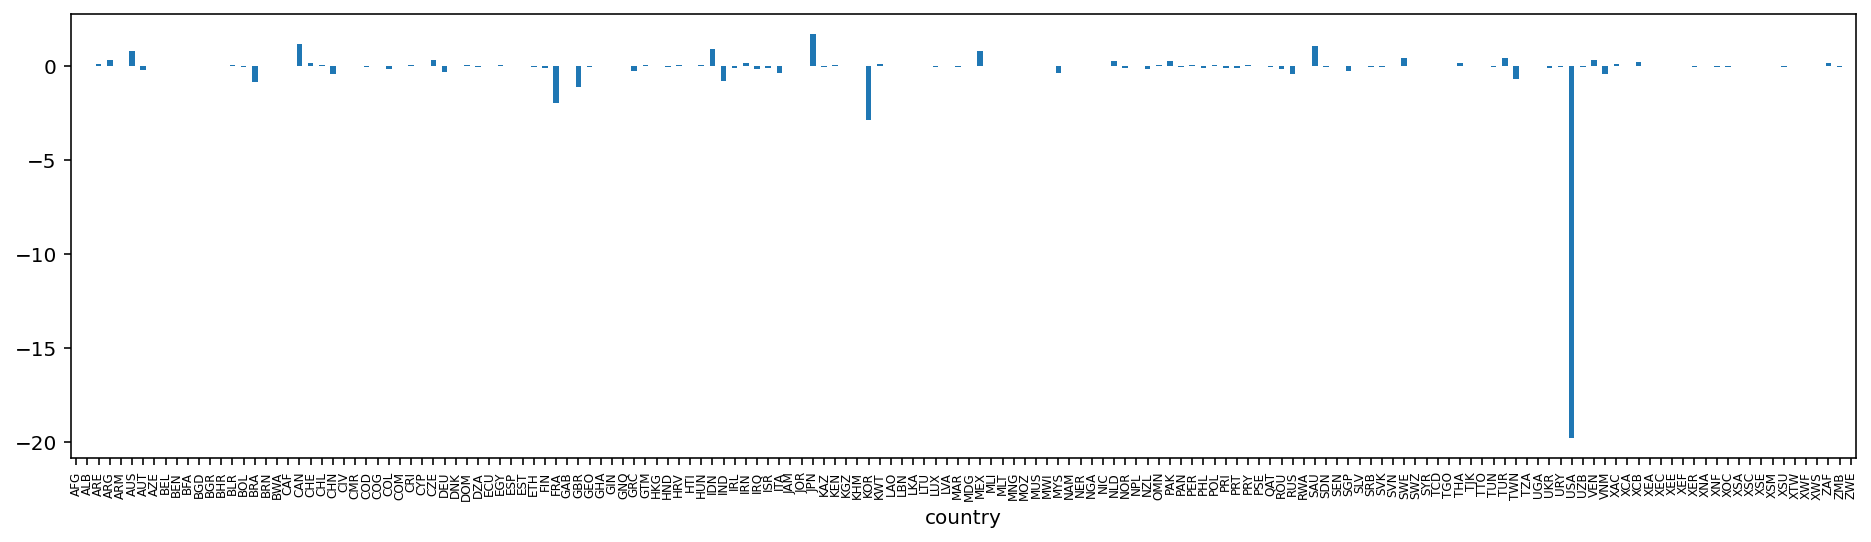

In [14]:
plot_1d_resid(check_resid(df, "Domestic Commodities"))

## Row 4: Factors

In [15]:
total_income = factor_income.sum(dim=["activity"])
df = update_block(df, total_income, ("Institution", "Regional Household"), "Factors")

direct_tax = (factor_bp - factor_income).sum(dim=["activity"])
df = update_block(df, direct_tax, ("Tax", "Income"), "Factors")

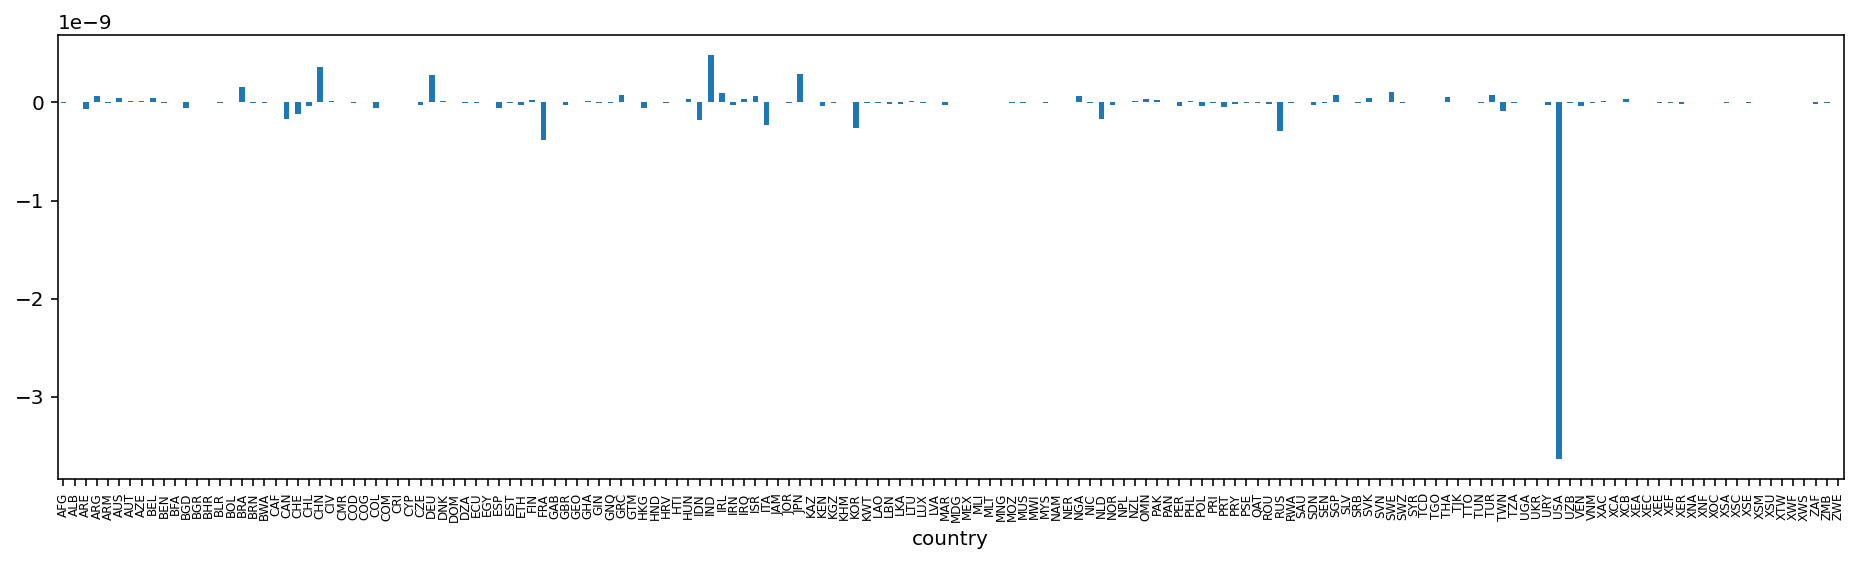

In [16]:
plot_1d_resid(check_resid(df, "Factors"))

## Row 5: Regional Household

In [17]:
# Tax revenues
df = update_block(
    df,
    import_duties.sum(dim=["source", "commodity"]),
    ("Institution", "Regional Household"),
    ("Tax", "Import Duty"),
)
df = update_block(
    df,
    export_duties.sum(dim=["destination", "commodity"]),
    ("Institution", "Regional Household"),
    ("Tax", "Export Duty"),
)

import_sales_tax = ((Fi_pp - Fi_bp) + (Ci_pp - Ci_bp) + (Ci_G_pp - Ci_G_bp) + (Ii_pp - Ii_bp)).sum(
    dim=["activity"]
)
df = update_block(df, import_sales_tax, ("Institution", "Regional Household"), "Import Sales Tax")

domestic_sales_tax = ((F_pp - F_bp) + (C_pp - C_bp) + (C_G_pp - C_G_bp) + (I_pp - I_bp)).sum(
    dim=["activity"]
)
df = update_block(
    df, domestic_sales_tax, ("Institution", "Regional Household"), "Domestic Sales Tax"
)

production_tax = (X_pp - X_bp).sum(dim=["activity", "commodity"])
df = update_block(df, production_tax, ("Institution", "Regional Household"), ("Tax", "Production"))

df = update_block(
    df, factor_tax.sum(dim="activity"), ("Institution", "Regional Household"), "Factor Tax"
)
df = update_block(
    df,
    factor_subsidity.sum(dim="activity"),
    ("Institution", "Regional Household"),
    "Factor Subsidity",
)
df = update_block(
    df, direct_tax.sum(dim="factor"), ("Institution", "Regional Household"), ("Tax", "Income")
)

# Capital depreciation
df = update_block(
    df, -K_dep, ("Institution", "Regional Household"), ("Other", "Capital Depreciation")
)


# # Incomes
household_spending = (C_pp + Ci_pp).sum(dim=["activity", "commodity"])
df = update_block(
    df,
    household_spending,
    ("Institution", "Private Household"),
    ("Institution", "Regional Household"),
)

govt_spending = (C_G_pp + Ci_G_pp).sum(dim=["activity", "commodity"])
df = update_block(
    df, govt_spending, ("Institution", "Government"), ("Institution", "Regional Household")
)

df = update_block(df, S, ("Institution", "Investment"), ("Institution", "Regional Household"))

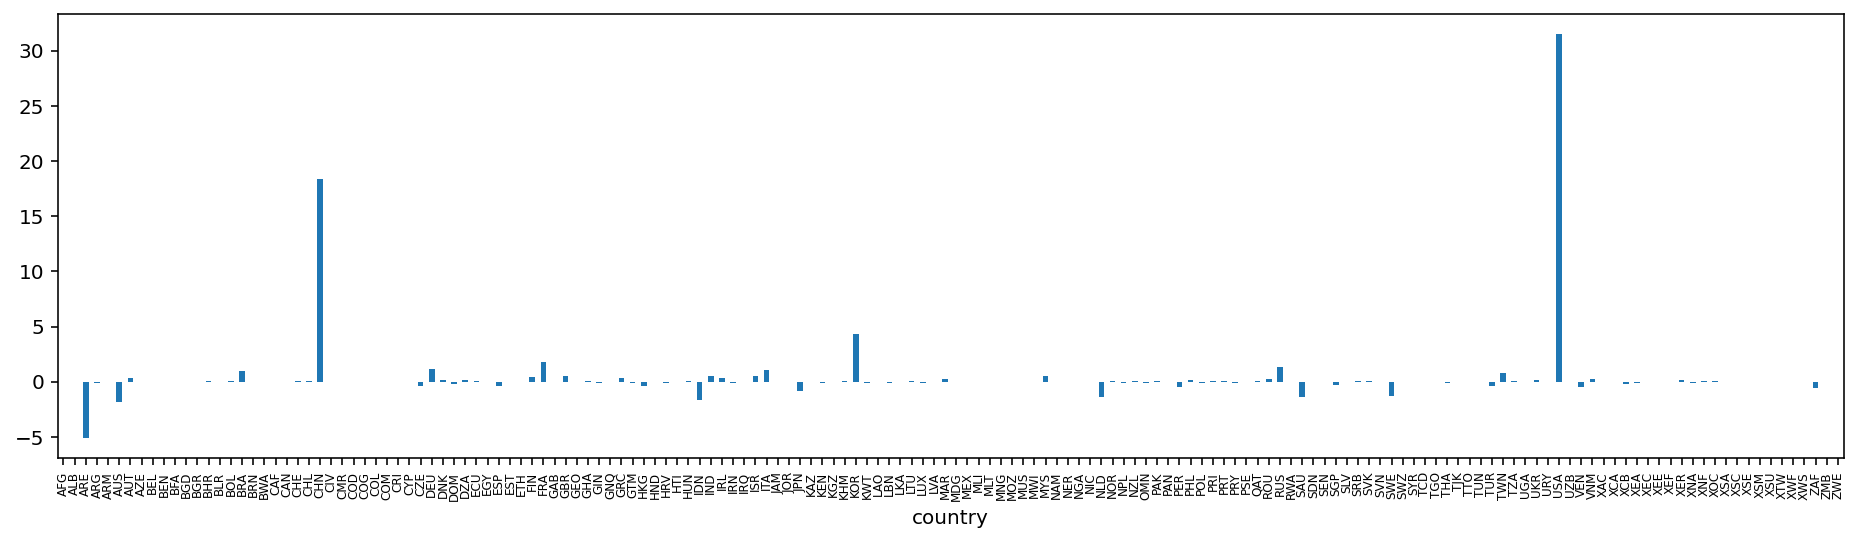

In [18]:
plot_1d_resid(check_resid(df, ("Institution", "Regional Household")))

## Private Household

In [19]:
hh_import_tax = Ci_pp - Ci_bp
hh_domestic_tax = C_pp - C_bp

df = update_block(
    df, hh_import_tax.sum(dim="activity"), "Import Sales Tax", ("Institution", "Private Household")
)
df = update_block(
    df,
    hh_domestic_tax.sum(dim="activity"),
    "Domestic Sales Tax",
    ("Institution", "Private Household"),
)

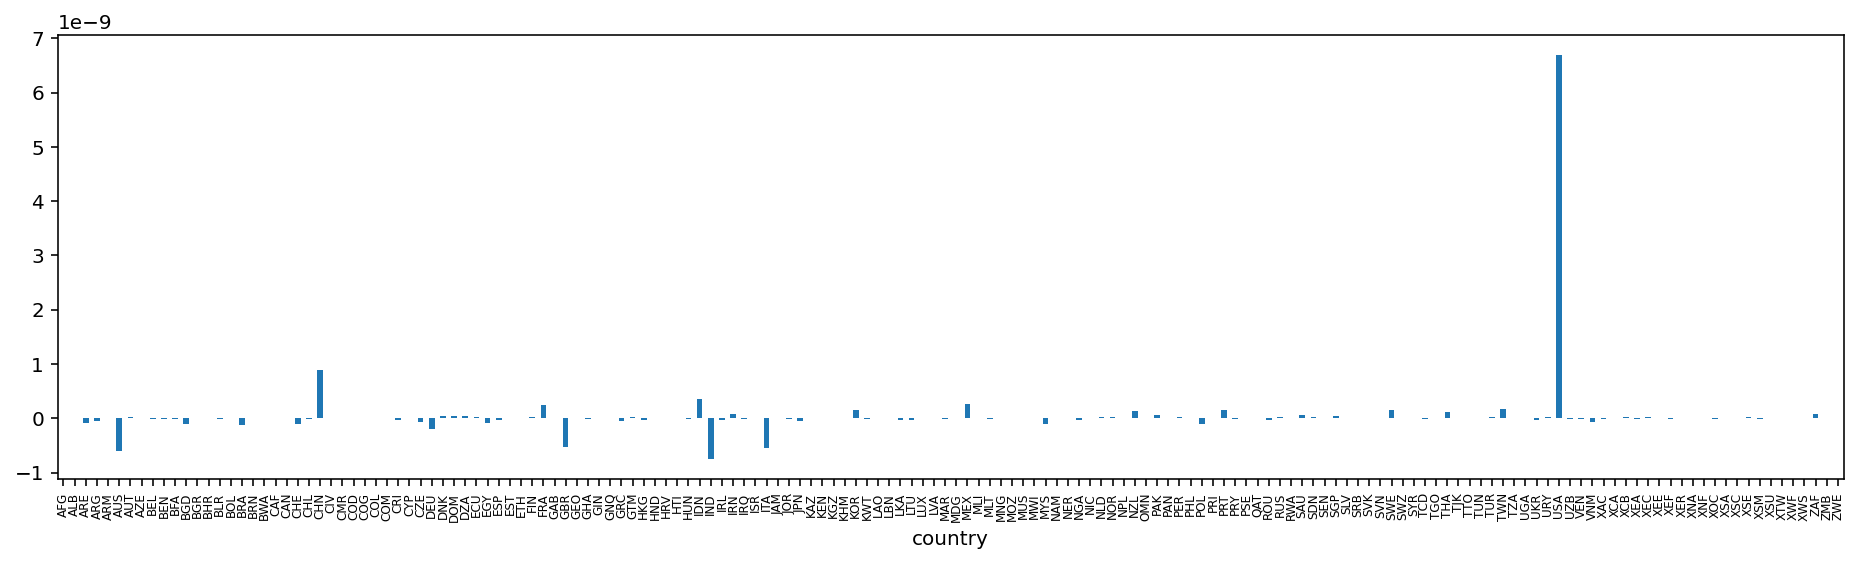

In [20]:
plot_1d_resid(check_resid(df, ("Institution", "Private Household")))

## Government

In [21]:
G_import_tax = Ci_G_pp - Ci_G_bp
G_domestic_tax = C_G_pp - C_G_bp

df = update_block(
    df, G_import_tax.sum(dim="activity"), "Import Sales Tax", ("Institution", "Government")
)
df = update_block(
    df, G_domestic_tax.sum(dim="activity"), "Domestic Sales Tax", ("Institution", "Government")
)

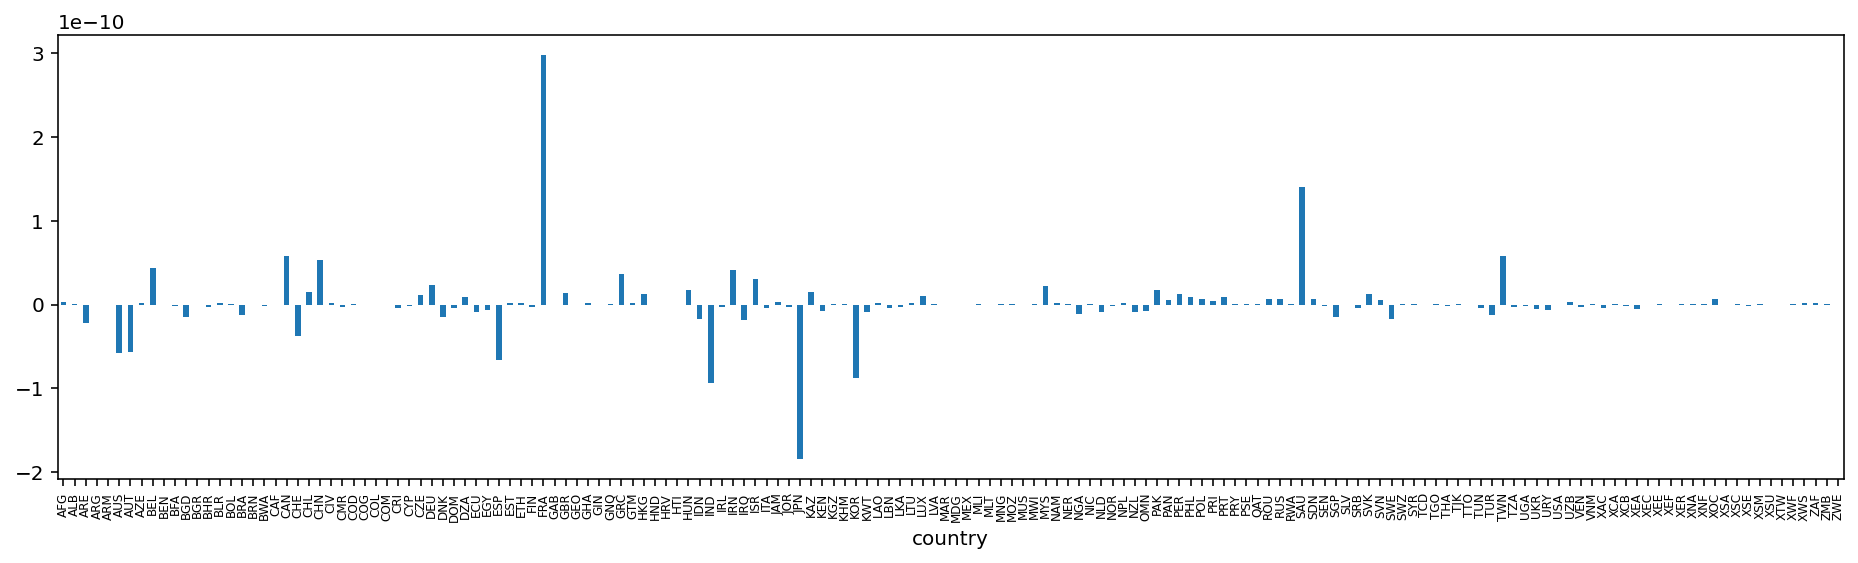

In [22]:
plot_1d_resid(check_resid(df, ("Institution", "Government")))

## Capital

In [23]:
# Two things: 1) VTWR - VST
# VST is margin exports. VTWR is margin imports
margin_spread = (margins_on_imports.sum(dim=["source"]) - export_of_margin_services_2).sum(
    dim=["commodity"]
)

# 2) VIWS - VTWR - VXWD
# VIWS is Im_cif, VTWR is margin imports, VXWD is fob exports
trade_balance = (
    Im_cif.sum(dim=["source"])
    - margins_on_imports.sum(dim=["source", "margin"])
    - Ex_fob.sum(dim=["destination"])
).sum(dim=["commodity"])

In [24]:
I_import_tax = Ii_pp - Ii_bp
I_domestic_tax = I_pp - I_bp

df = update_block(
    df, I_import_tax.sum(dim="activity"), "Import Sales Tax", ("Institution", "Investment")
)
df = update_block(
    df, I_domestic_tax.sum(dim="activity"), "Domestic Sales Tax", ("Institution", "Investment")
)
df = update_block(df, K_dep, ("Institution", "Investment"), ("Other", "Capital Depreciation"))
df = update_block(
    df, margin_spread.sel(margin=margin_codes), ("Institution", "Investment"), "Export Margin"
)
df = update_block(df, trade_balance, ("Institution", "Investment"), ("Trade", "Rest of World"))

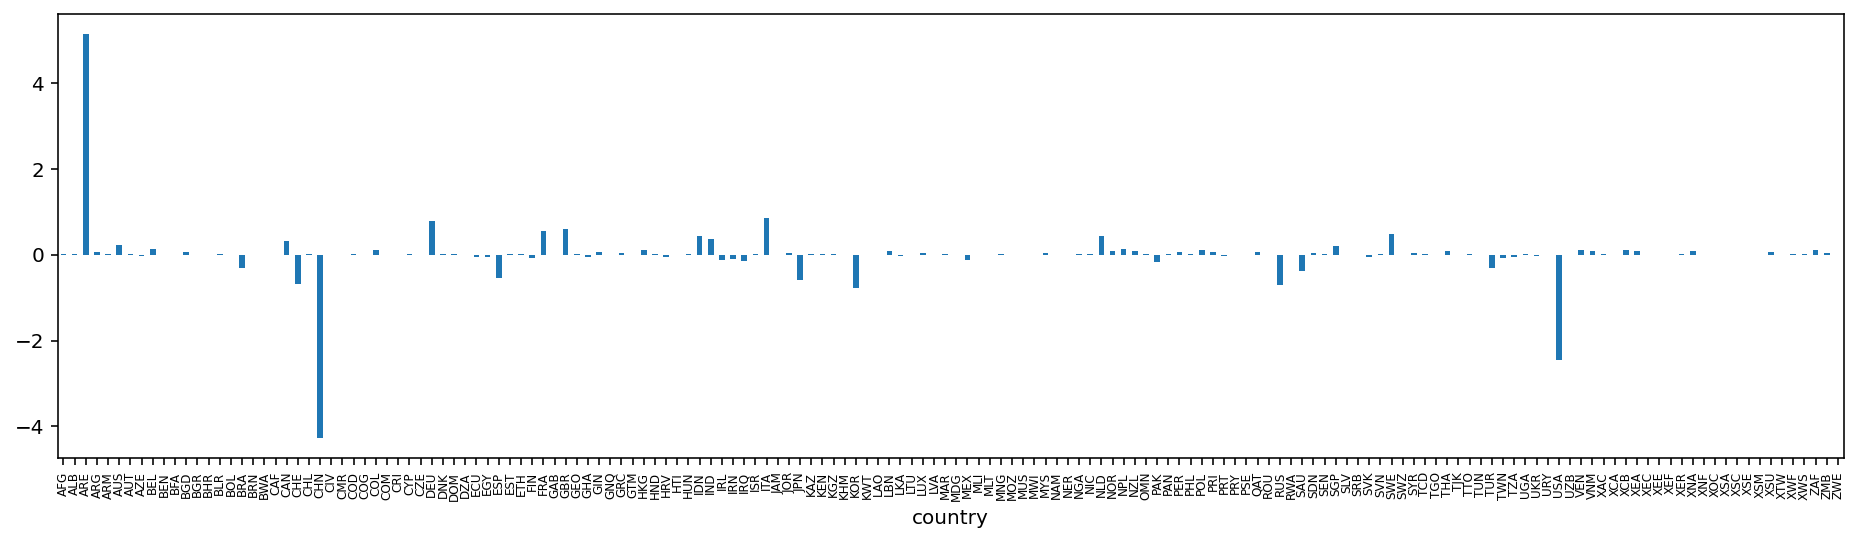

In [25]:
plot_1d_resid(check_resid(df, ("Institution", "Investment")))

## Check Taxes

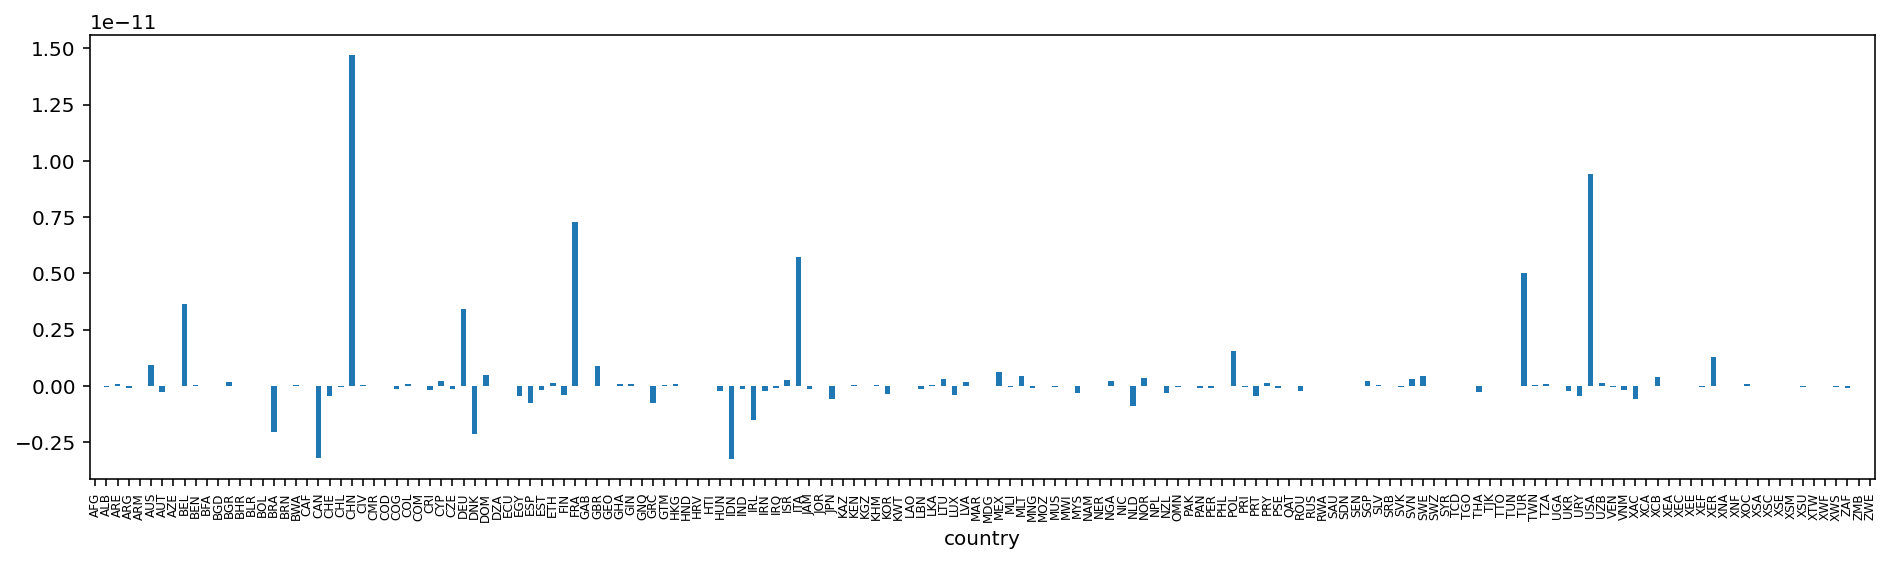

In [26]:
plot_1d_resid(check_resid(df, "Import Sales Tax"))

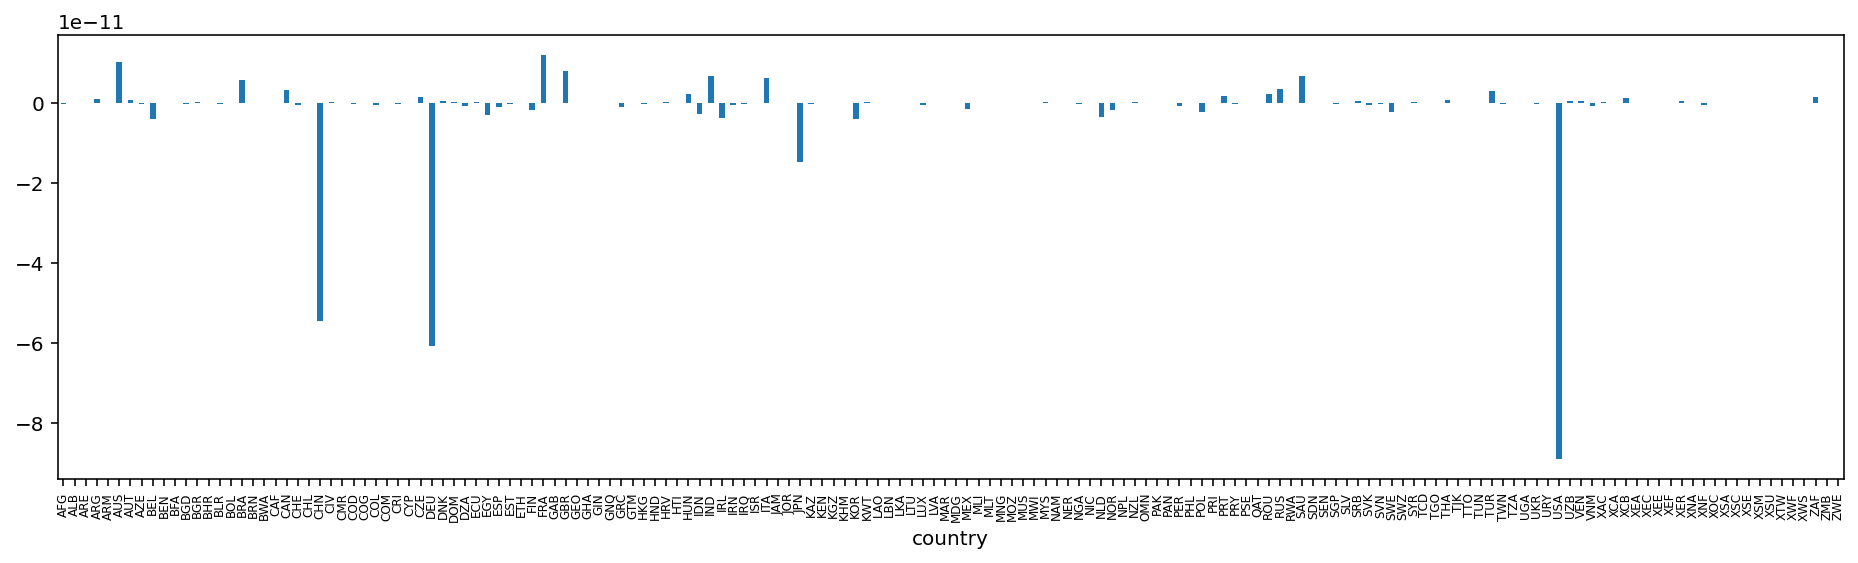

In [27]:
plot_1d_resid(check_resid(df, "Domestic Sales Tax"))

In [28]:
(df.sel(row_group="Factor Tax").sum() - df.sel(col_group="Factor Tax").sum()).item()

0.0

In [29]:
(df.sel(row_group="Factor Subsidity").sum() - df.sel(col_group="Factor Subsidity").sum()).item()

-5.820766091346741e-11

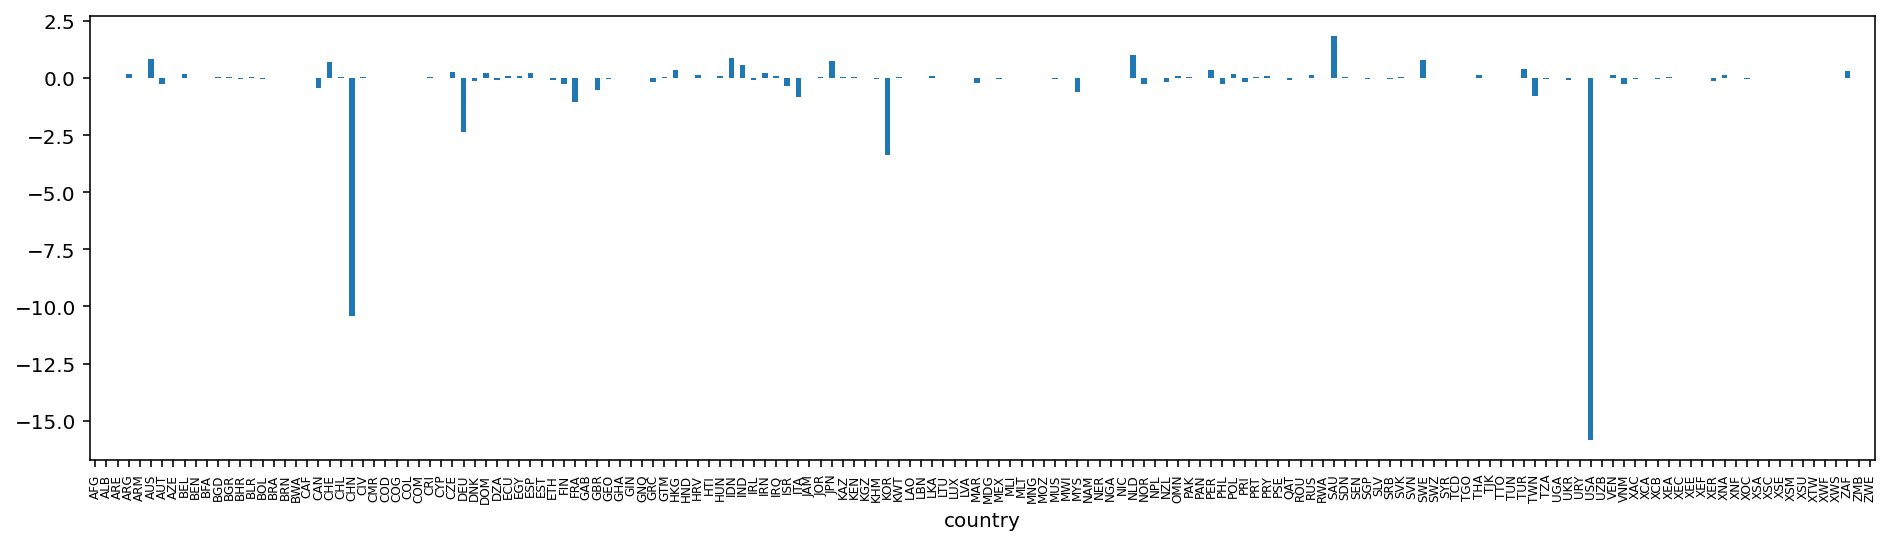

In [30]:
plot_1d_resid(check_resid(df, ("Tax", "Production")))

In [31]:
(
    df.sel(row_group="Tax", row_value="Income").sum()
    - df.sel(col_group="Tax", col_value="Income").sum()
).item()

-9.313225746154785e-10

## Import Margins

In [32]:
Im_margin_diag = np.stack(
    [np.diag(x) for x in Im_margin.sum(dim="commodity").sel(margin=margin_codes).T]
).transpose(2, 1, 0)
df.loc[dict(row_group="Export Margin", col_group="Import Margin")] = Im_margin_diag

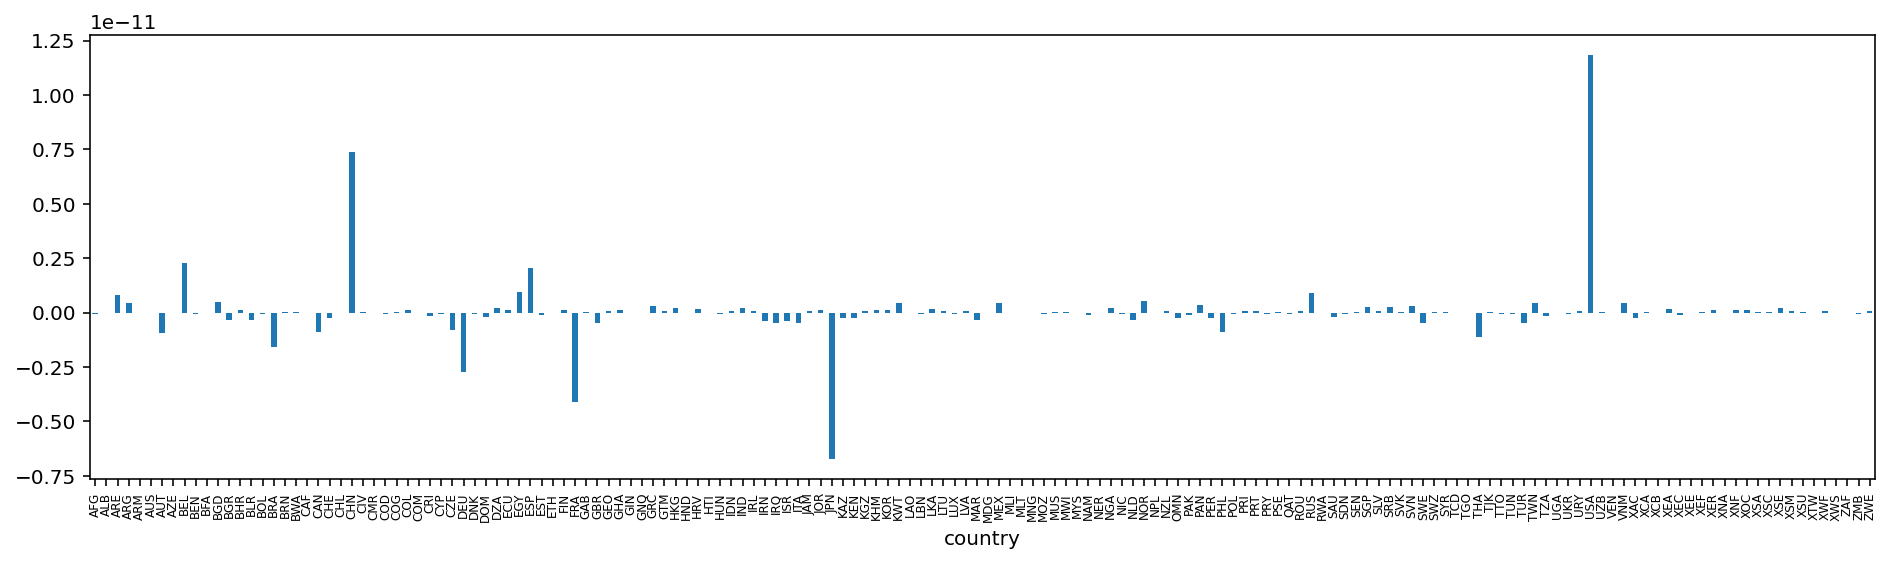

In [33]:
plot_1d_resid(check_resid(df, "Import Margin"))

## Export Margins

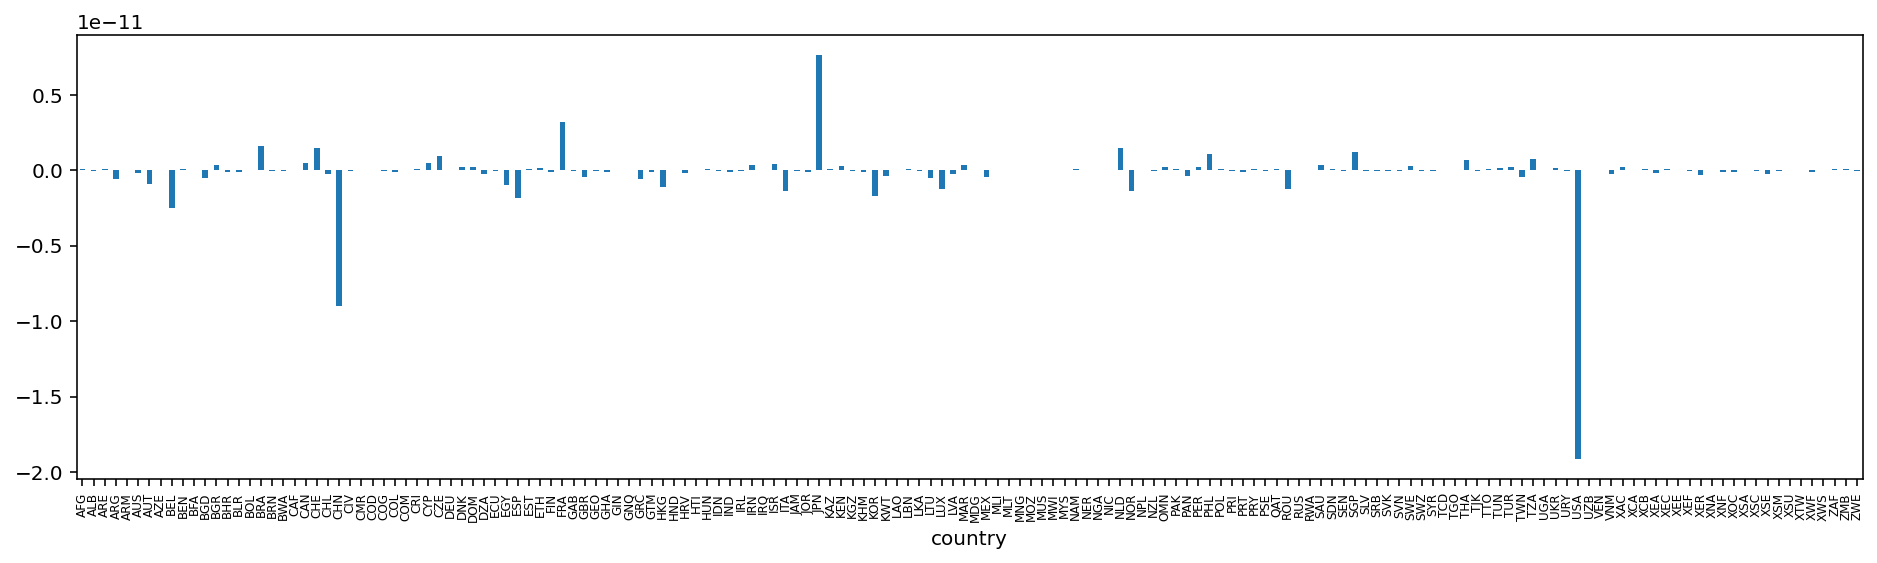

In [34]:
plot_1d_resid(check_resid(df, "Export Margin"))

## Rest of World

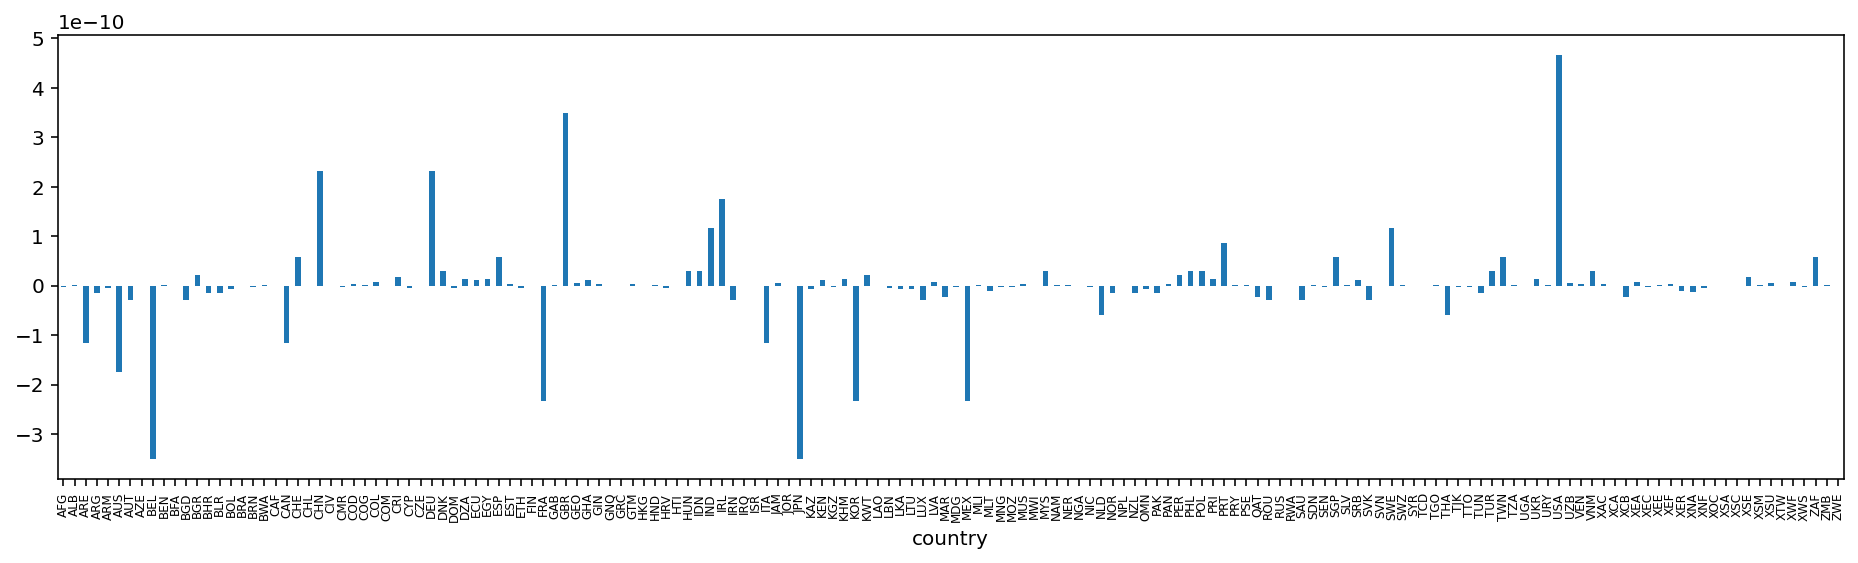

In [35]:
plot_1d_resid(check_resid(df, "Trade"))

# Total Errors

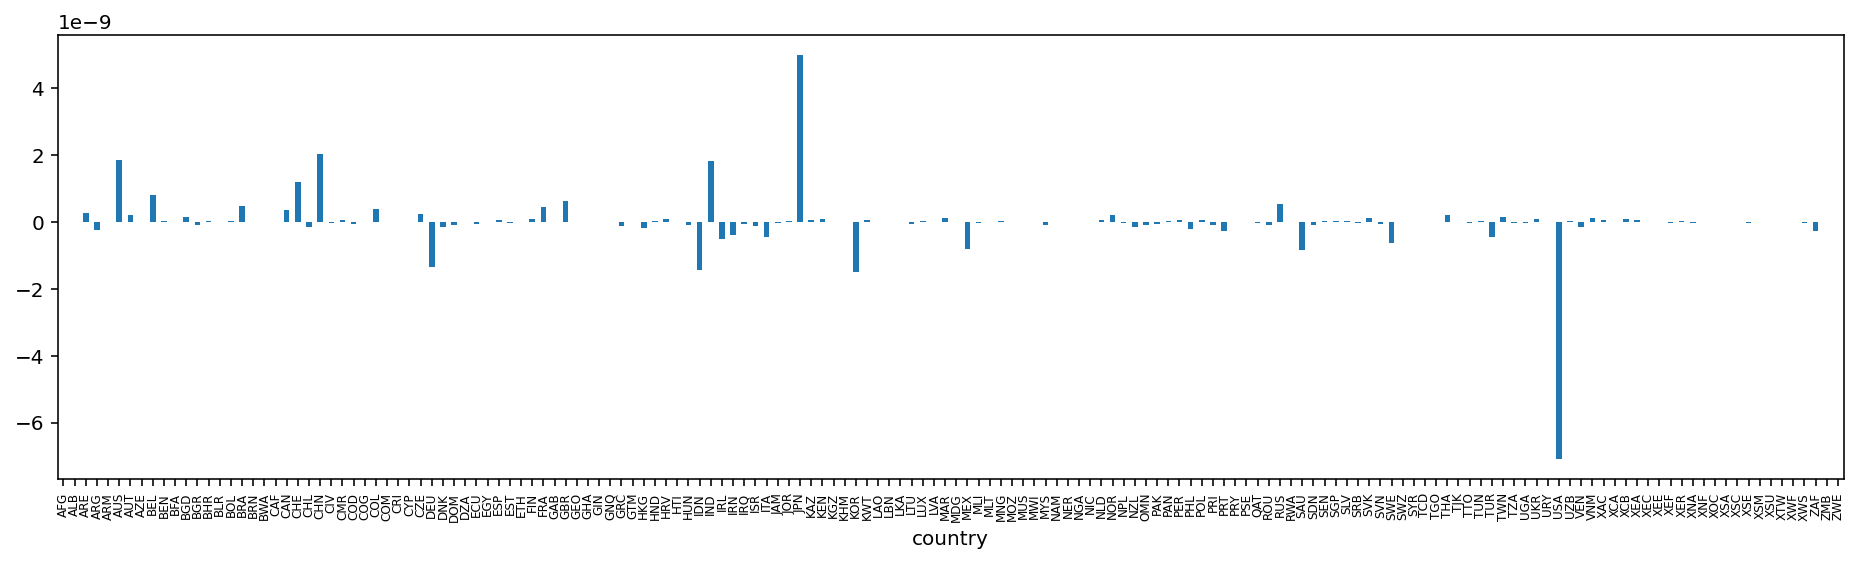

In [36]:
plot_1d_resid((df.sum(dim="row") - df.sum(dim="column").values).sum(dim="column"))

In [37]:
# import cf_xarray as cfxr
# encoded = cfxr.encode_multi_index_as_compress(xr.Dataset({'SAM':df}), ['row', 'column'])
# encoded.to_netcdf('GTAP_SAM_with_errors.nc')